In [135]:
import matplotlib.pyplot as plt
from joblib import load, dump
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import warnings, os
from glob import glob
from sklearn.utils import shuffle

import seaborn as sns
import scipy.stats as stats
import tensorflow as tf

import aggmap
from aggmap import loadmap, aggmodel


import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"
sns.set(style= 'white',font_scale = 1.2)

## fix random seed to get repeatale results
seed = 666
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)
warnings.filterwarnings("ignore")

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() #(x_train, y_train), (x_test, y_test)
mnist_labels_dict = {0: 'T-shirt/top',1: 'Trouser',2: 'Pullover',
                     3: 'Dress',4: 'Coat', 5: 'Sandal', 
                     6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
testY = pd.get_dummies(y_test).values.astype(float)
shuffled_cols = shuffle(range(784), random_state=7) #the training shufffle random seed is 7, so do not change this

In [3]:
results_save_folder = './imgs'
data_save_folder = '/raid/shenwanxiang/aggmap/fmnist/correlation/'

mp_ORSAgg1 = loadmap(os.path.join(data_save_folder, 'mp_ORSAgg1.mp'))
mp_ORSAggC4 = loadmap(os.path.join(data_save_folder, 'mp_ORSAggC4.mp'))
mp_ORSAggC10 = loadmap(os.path.join(data_save_folder, 'mp_ORSAggC10.mp'))
mp_ORSAggV4 = loadmap(os.path.join(data_save_folder, 'mp_ORSAggV4.mp'))

In [69]:
model_OR1 = tf.keras.models.load_model('./model_results/model_OR1.h5')
model_ORS1 = tf.keras.models.load_model('./model_results/model_ORS1.h5')
model_ORSAgg1 = tf.keras.models.load_model('./model_results/model_ORSAgg1.h5')
model_ORSAggC4 = tf.keras.models.load_model('./model_results/model_ORSAggC4.h5')
model_ORSAggC10 = tf.keras.models.load_model('./model_results/model_ORSAggC10.h5')
model_ORSAggV4 = tf.keras.models.load_model('./model_results/model_ORSAggV4.h5')

In [70]:
mp_ORSAggC4.cluster_channels

4

In [6]:
def gauss_noisy(X, c = 0.38):
    ''' 
    X: 4D array, n,w,h,c
    '''
    X = X/255.
    np.random.seed(123)
    X = np.clip(X + np.random.normal(size = X.shape, scale = c), 0, 1) * 255
    return X

stddevs = np.arange(0, 0.8, 0.12)

testX_noisys = []
testX_noisy_names = []
for stddev in stddevs:
    testX = x_test.reshape(-1, 28,28, 1)
    testX_noisy = gauss_noisy(testX, c = stddev)
    testX_noisys.append(testX_noisy)
    testX_noisy_names.append('stddev: %.2f' % stddev)
    

testX_noisys_shuffle = []
for testX_noisy in testX_noisys:
    testX_noisy = testX_noisy.reshape(-1, 28*28)
    testX_noisy = testX_noisy.T[shuffled_cols].T.reshape(-1, 28,28, 1)
    testX_noisys_shuffle.append(testX_noisy)
    
    
testX_noisys_shuffle_ORSAgg1 = []
for testX_noisy_shuffle in testX_noisys_shuffle:
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, 28*28)
    testX_noisy_shuffle = mp_ORSAgg1.batch_transform(testX_noisy_shuffle, scale = False, n_jobs=10)
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, mp_ORSAgg1.fmap_shape[0],mp_ORSAgg1.fmap_shape[1], 1)
    testX_noisys_shuffle_ORSAgg1.append(testX_noisy_shuffle)
    
testX_noisys_shuffle_ORSAggC4 = []
for testX_noisy_shuffle in testX_noisys_shuffle:
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, 28*28)
    testX_noisy_shuffle = mp_ORSAggC4.batch_transform(testX_noisy_shuffle, scale = False, n_jobs=10)
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, mp_ORSAggC4.fmap_shape[0],mp_ORSAggC4.fmap_shape[1], 4)
    testX_noisys_shuffle_ORSAggC4.append(testX_noisy_shuffle)
    
testX_noisys_shuffle_ORSAggC10 = []
for testX_noisy_shuffle in testX_noisys_shuffle:
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, 28*28)
    testX_noisy_shuffle = mp_ORSAggC10.batch_transform(testX_noisy_shuffle, scale = False, n_jobs=10)
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, mp_ORSAggC10.fmap_shape[0],mp_ORSAggC10.fmap_shape[1], 10)
    testX_noisys_shuffle_ORSAggC10.append(testX_noisy_shuffle)
    

testX_noisys_shuffle_ORSAggV4 = []
for testX_noisy_shuffle in testX_noisys_shuffle:
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, 28*28)
    testX_noisy_shuffle = mp_ORSAggV4.batch_transform(testX_noisy_shuffle, scale = False, n_jobs=10)
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, mp_ORSAggV4.fmap_shape[0],mp_ORSAggV4.fmap_shape[1], 4)
    testX_noisys_shuffle_ORSAggV4.append(testX_noisy_shuffle)

100%|##########| 10000/10000 [00:37<00:00, 268.95it/s]


In [71]:
acc = []
loss = []
for xor, xors, xagg1, xaggc4, xaggc10, xaggv4 in zip(testX_noisys, 
                                                    testX_noisys_shuffle,
                                                    testX_noisys_shuffle_ORSAgg1, 
                                                    testX_noisys_shuffle_ORSAggC4, 
                                                    testX_noisys_shuffle_ORSAggC10, 
                                                    testX_noisys_shuffle_ORSAggV4):
    ls1, acc1 = model_OR1.evaluate(xor/255., testY, verbose = 0)
    ls2, acc2 = model_ORS1.evaluate(xors/255., testY, verbose = 0)
    ls3, acc3 = model_ORSAgg1.evaluate(xagg1/255., testY, verbose = 0)

    ls4, acc4 = model_ORSAggC4.evaluate(xaggc4/255., testY, verbose = 0)
    ls5, acc5 = model_ORSAggC10.evaluate(xaggc10/255., testY, verbose = 0)
    
    ls6, acc6 = model_ORSAggV4.evaluate(xaggv4/255., testY, verbose = 0)    
    
    
    acc.append([acc1, acc2, acc3, acc4, acc5, acc6])
    loss.append([ls1, ls2, ls3, ls4, ls5, ls6])

In [119]:
index = ["%.2f" % i for i in stddevs] 

df1 = pd.DataFrame(acc, columns = ['OR1', 'ORS1', 'ORSAgg1', 'ORSAggC4', 'ORSAggC10', 'ORSAggV4'], index = index)
df2 = pd.DataFrame(loss, columns = ['OR1', 'ORS1', 'ORSAgg1', 'ORSAggC4', 'ORSAggC10', 'ORSAggV4'], index = index)


df1.index.name = 'Guassian noise stddev'
df2.index.name = 'Guassian noise stddev'

df1.to_csv(os.path.join(results_save_folder, 'performance_test_gauss_acc.csv'))
df2.to_csv(os.path.join(results_save_folder, 'performance_test_gauss_loss.csv'))


In [125]:
select = ['OR1',  'ORSAggC4'] 
df1 = df1[select]
df2 = df2[select]

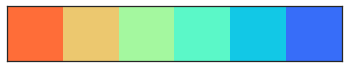

In [155]:
cols = df1.mean().sort_values().index

c = sns.color_palette("rainbow_r", 6).as_hex()
color = [c[1], c[2]]
sns.palplot(c)

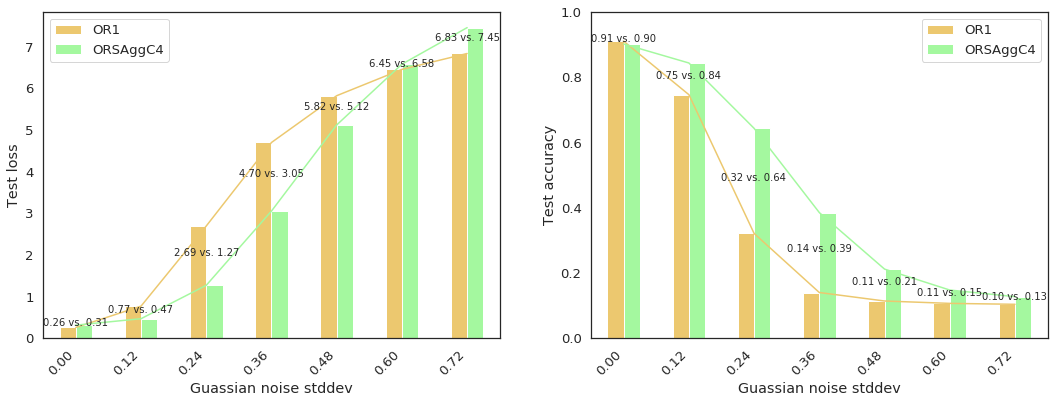

In [158]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharex=False, sharey=False, )
ax2, ax1 = axes        

df1[cols].plot(kind = 'line',  color = color, ax = ax1, legend = False)
df1[cols].plot(kind = 'bar',  color = color, ax = ax1, ylim = (0,1))
for x,y in enumerate(df1.index):
    m1 = df1.iloc[x].iloc[0]
    m2 = df1.iloc[x].iloc[1]
    v = '%.2f vs. %.2f' % (m1,m2)
    ax1.annotate(v, xy = (x-0.5, df1.iloc[x].mean()+0.001), fontsize= 10)
    
    
ax1.set_ylabel('Test accuracy')
ax1.set_xticklabels(labels = df1.index,rotation=45, ha = 'right')

df2[cols].plot(kind = 'line',  color = color, ax = ax2, legend = False)
df2[cols].plot(kind = 'bar', color = color, ax = ax2)

for x,y in enumerate(df2.index):
    m1 = df2.iloc[x].iloc[0]
    m2 = df2.iloc[x].iloc[1]
    v = '%.2f vs. %.2f' % (m1,m2)
    ax2.annotate(v, xy = (x-0.5, df2.iloc[x].mean()), fontsize= 10)
        
ax2.set_ylabel('Test loss')
ax2.set_xticklabels(labels = df2.index,rotation=45, ha = 'right')

plt.savefig(os.path.join(results_save_folder, 'performance_Guassian_Noise_test.png'), bbox_inches='tight', dpi=300)

In [157]:
testX = x_test.reshape(-1, 28,28, 1)
model_OR1.evaluate(testX/255., testY, verbose=0)

[0.25871314043998717, 0.9107]

In [129]:
df2

,OR1,ORSAggC4
Guassian noise stddev,,
0.00,0.258713,0.313952
0.12,0.770487,0.469180
0.24,2.693127,1.270379
0.36,4.696574,3.051845
0.48,5.819394,5.117610
0.60,6.450376,6.575535
0.72,6.831962,7.452798


In [130]:
df1

,OR1,ORSAggC4
Guassian noise stddev,,
0.00,0.9107,0.9022
0.12,0.7468,0.8439
0.24,0.3213,0.6436
0.36,0.1402,0.3853
0.48,0.1142,0.2120
0.60,0.1069,0.1478
0.72,0.1041,0.1275


In [53]:
import sys,os
import pandas as pd
import numpy as np
import warnings

import tensorflow as tf
from sklearn.utils import shuffle
from joblib import load, dump
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap
import aggmap

warnings.filterwarnings("ignore")

def imshow(x_arr,  ax,  color_list = ['#ff0c00','#25ff00', '#1300ff','#d000ff','#e2ff00', 
              '#00fff6', '#ff8800', '#fccde5','#178b66', '#8a0075'], x_max = 255, vmin = -1, vmax = 1,):
    
    
    assert x_arr.ndim == 3, 'input must be 3d array!'
    w, h, c = x_arr.shape
    assert len(color_list) >= c, 'length of the color list should equal or larger than channel numbers'
    
    x = x_arr.copy()
    x[x == 0] = 'nan'

    xxx = x_arr.sum(axis=-1)
    xxx[xxx != 0] = 'nan'
        
    
    cmaps = [sns.light_palette(color, n_colors =  100, reverse=False) for color in color_list]

    for i in range(c):
        data = x[:,:,i]/x_max
        sns.heatmap(data, cmap = cmaps[i],  vmin = vmin, vmax = vmax,  
                    yticklabels=False, xticklabels=False, cbar=False, ax=ax, ) # linewidths=0.005, linecolor = '0.9'

    sns.heatmap(xxx, vmin=0, vmax=1, cmap = 'Greys', yticklabels=False, xticklabels=False, cbar=False, ax=ax)
    #-100000
    
    ax.axhline(y=0, color='grey',lw=2, ls =  '--')
    ax.axhline(y=data.shape[0], color='grey',lw=2, ls =  '--')
    
    ax.autoscale()
    ax.axvline(x=data.shape[1], color='grey',lw=2, ls =  '--')  
    ax.axvline(x=0, color='grey',lw=2, ls =  '--')


def imshow_wrap(x):
    fig, ax = plt.subplots(figsize=(4,4))
    imshow(x.astype(float), ax=ax, x_max = 255, vmin = -0.001, vmax=1)
    

def tracked_orignal_change(orignal_image, new_mp):
    
    #mp = mp_ORSAggS4
    #orignal_image = trainX_OR1[0]
    df = new_mp._S.df.copy()
    SI = df.groupby('Subtypes').apply(lambda x:x.index.to_list())
    M, N, C = orignal_image.shape
    v = orignal_image.reshape(M*N*C, )
    arr_res = []
    for i, j in SI.items():
        j = [int(k.replace('p-',''))-1 for k in j]
        arr_1d = np.zeros(M*N, )
        arr_1d[j] = v[j]
        arr = arr_1d.reshape(M, N)  
        arr_res.append(arr)
    arr_tracked = np.stack(arr_res, axis=-1)
    return arr_tracked


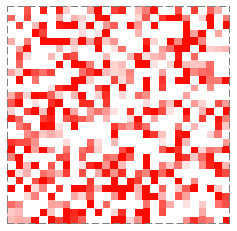

In [54]:
imshow_wrap(xors[0])

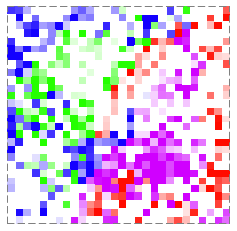

In [59]:
imshow_wrap(xaggv4[0])

In [ ]:
xor, xors, xagg1, xaggc4, xaggc10, xaggv4 